# Computer Vision Business Recommendations
#### Luis Estrada, Michael Eugene, Maddie Hince, Kilmar Lazo, Cat Murad, and Elijah Soba

## Overview

Computer Vision wants to break into the movie production industry, but needs insight regarding what types of movies to make. 

We have recommended three courses of action that will allow Computer Vision's films to be successful at the box office:
- Produce a movie in the animation genre (with a the possibility of a comedy sub-genre)
- Allocate $80 million towards movie production. 
- Allocate more marketing effort towards international audiences (rather than domestic audiences).

We based these recommendations off of three high-priority metrics:
- Highest-rated movie genres
- Budget-to-box office ratio
- Which production studios gross the highest
    - Which genres of movies these production studios produce

## Business Understanding

- Computer Vision wants to establish a movie studio to create video and movie content.
- Computer Vision is new to the movie / video market and needs guidance regarding what types of movies to create. 
- Providing insights into what types of movies are doing best at the box office will allow Computer Vision to allocate their budget towards creating a successful film. 

## Data Understanding

In [1]:
# Import all necessary libraries
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

# Ignore warnings from library functions
warnings.filterwarnings('ignore')

# Set the style for plots 
sns.set_style('darkgrid')
sns.set_context('notebook')
sns.set()

We used data from three main sources to make recommendations for Computer Vision: 
- Box Office Mojo
- The Numbers
- IMDB (Internet Movie Database)

### Understanding the Box Office Mojo Dataset

In [2]:
# Define filepath & read in the data 
filepath = 'zippedData/bom.movie_gross.csv.gz'
movie_gross_df = pd.read_csv(filepath)

In [3]:
# Take a preliminary look at the data 
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [4]:
# Take a look at the data frame information
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


From looking at the information we can see immediately that there are a couple things wrong with the data:
- There are missing values in studio, domestic gross, and foreign gross
- Foreign gross is represented as an object instead of a float
- Year is represented as an integer, but it is probably better to have it as a datetime object

In [5]:
# Let's see what percentage of the studio data is missing 
pct_missing_std = movie_gross_df.studio.isna().sum()/len(movie_gross_df.title)
print(f'Missing studio data represents {pct_missing_std*100}% of the data')

Missing studio data represents 0.14762326542663123% of the data


In [6]:
# Let's see what percentage of the domestic gross data is missing 
pct_missing_dom = movie_gross_df.domestic_gross.isna().sum()/len(movie_gross_df.title)
print(f'Missing domestic gross data represents {pct_missing_dom*100}% of the data')

Missing domestic gross data represents 0.8266902863891349% of the data


In [7]:
# Let's see what percentage of the foreign gross data is missing 
pct_missing_for = movie_gross_df.foreign_gross.isna().sum()/len(movie_gross_df.title)
print(f'Missing foreign gross data represents {pct_missing_for*100}% of the data')

Missing foreign gross data represents 39.85828166519043% of the data


### Understanding The Numbers Dataset

In [8]:
# Define filepath & read in the data 
filepath = 'zippedData/tn.movie_budgets.csv.gz'
budget_df = pd.read_csv(filepath)

In [9]:
# Take a preliminary look at the data
budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [10]:
# Take a look at the data frame information
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


From looking at the information, we can see a few important things
- There are no missing (NaN) values
- All of the numerical columns are strings instead of floats

In [11]:
# Let's see if there are any 0 values, which would be considered missing 
either_miss = len(budget_df[(budget_df['domestic_gross'] == '$0') | (budget_df['worldwide_gross'] == '$0')])
both_miss = len(budget_df[(budget_df['domestic_gross'] == '$0') & (budget_df['worldwide_gross'] == '$0')])
just_dom = len(budget_df[budget_df['domestic_gross'] == '$0'])
just_world = len(budget_df[budget_df['worldwide_gross'] == '$0'])
len_dataset = len(budget_df['domestic_gross'])
print(f'Number of missing gross values from either column {either_miss}')
print(f'Number of missing gross values from both columns {both_miss}')
print(f'Number of missing gross values from just domestic {just_dom}')
print(f'Number of missing gross values from just worldwide {just_world}')
print(f'Number of items in the entire dataset {len_dataset}')

Number of missing gross values from either column 548
Number of missing gross values from both columns 367
Number of missing gross values from just domestic 548
Number of missing gross values from just worldwide 367
Number of items in the entire dataset 5782


In [12]:
# Because there are numbers with 0 domestic and worldwide gross, lets see what fraction of the dataset it is
pct_0_dom = just_dom/len_dataset
print(f'Percentage of the data that is missing from the domestic gross column {pct_0_dom*100}')
pct_0_world = just_world/len_dataset
print(f'Percentage of the data that is missing from the worldwide gross column{pct_0_world*100}')

Percentage of the data that is missing from the domestic gross column 9.47768938083708
Percentage of the data that is missing from the worldwide gross column6.347284676582497


### Understanding the IMDB Dataset

In [13]:
# Establish a connection with SQL databasae and read in the data
filename = 'zippedData/im.db'
conn = sqlite3.connect(filename)
q = """SELECT *
       FROM movie_ratings
       JOIN movie_basics USING(movie_id)
       WHERE movie_basics.start_year >= 2010"""
ratings_df = pd.read_sql(q, conn)

In [14]:
# Take a preliminary look at the data
ratings_df.head()

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,7.0,77,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,7.2,43,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,6.9,4517,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,6.1,13,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,6.5,119,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [15]:
# Take a look at the data frame information
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   averagerating    73856 non-null  float64
 2   numvotes         73856 non-null  int64  
 3   primary_title    73856 non-null  object 
 4   original_title   73856 non-null  object 
 5   start_year       73856 non-null  int64  
 6   runtime_minutes  66236 non-null  float64
 7   genres           73052 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


From looking at the information, we can see that there are some missing values in the runtime column and data types for columns are as expected

### Summary 
The data from Box Office Mojo included movie domestic and foreign gross, and movie production studio.
- Dataset contained in a .csv file
- Approximately 39% missing data in foreign gross column

Data from The Numbers included production budget and worldwide gross information.
- Dataset contained in a .csv file
- Approximately 6% missing data in worldwide gross

Data from IMDB included general movie information such as title, average ratings, and genres.
- Data represented as a relational SQL database
- Most analysis done using __movie_basics__ and __movie_ratings__ tables

We only considered movies in each dataset that had been released in 2010 or later.

## Data Preparation

### Preparing the Box Office Mojo Dataset

In [16]:
# Let's recast foregin_gross as a float 
str_to_float = lambda x: float(str(x).replace(',', ''))
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].map(str_to_float)

In [17]:
# Let's test to see if the data type actually changed 
assert movie_gross_df['foreign_gross'].dtype  == np.float64

In [18]:
# Let's replace missing studios with 'IND' representing independent
movie_gross_df['studio'] = movie_gross_df['studio'].fillna('IND')

In [19]:
# Test to see if there are any missing values in the studio column
assert movie_gross_df['studio'].isna().sum() == 0

In [20]:
# The missing % of data for domestic gross is small, so lets delete those rows
movie_gross_df = movie_gross_df.dropna(axis=0, subset=['domestic_gross'])

Because the amount of missing data from the foreign gross column is too much, we must impute the missing values. We impute missing values by calculating the median % change between foreign and domestic gross and using that to give an estimate of foreign gross as a function of domestic

In [21]:
# That is too much, so lets find the median pct change between domestic and foreign films
med_pct_change = ((movie_gross_df['foreign_gross'] - movie_gross_df['domestic_gross'])/movie_gross_df['domestic_gross']).median()
print(med_pct_change)

0.6315266036797613


In [22]:
# Now that we have the median % change, lets impute the missing foreign values 
impute_change = movie_gross_df['domestic_gross'] + (movie_gross_df['domestic_gross'] * med_pct_change)
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].fillna(impute_change)

In [23]:
# Test that we now have no more NaN values in the data 
assert movie_gross_df['foreign_gross'].isna().sum() == 0

In [24]:
# Finally, test to see if there are any missing values anywhere in the data 
assert movie_gross_df.isna().sum().sum() == 0

In [25]:
# Let's feature engineer a new feature that can be useful to our understanding of gross as a whole
movie_gross_df['total_gross'] = movie_gross_df['foreign_gross'] + movie_gross_df['domestic_gross']
# And convert every value into a float
# movie_gross_df['total_gross'] = movie_gross_df['total_gross'].map(str_to_float)

# Let's normalize the data to millions to make numbers more manageable
movie_gross_df['total_gross'] = movie_gross_df['total_gross']/1000000
movie_gross_df['domestic_gross'] = movie_gross_df['domestic_gross']/1000000
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross']/1000000

In [26]:
# Let's change the title to avoid any issues with spacing
movie_gross_df['title'] = movie_gross_df['title'].map(lambda x: x.strip().lower().replace(" ", ""))

### Preparing the Numbers Dataset

In [27]:
# Let's define a function that will parse through a string of $xxx,xxx,xxx and turn it into a float
money_to_float = lambda x: float(x.replace('$','').replace(',',''))

In [28]:
# Let's test to make sure this function is behaving the way that we anticipate
assert money_to_float('$1,000') == 1000

In [29]:
# Update the dtype of the production_budget column 
budget_df['production_budget'] = budget_df['production_budget'].map(money_to_float)

In [30]:
# Update the dtype of the domestic_gross column 
budget_df['domestic_gross'] = budget_df['domestic_gross'].map(money_to_float)

In [31]:
# Update the dtype of the worldwide_gross column 
budget_df['worldwide_gross'] = budget_df['worldwide_gross'].map(money_to_float)

In [32]:
# Test to make sure it worked
assert budget_df['production_budget'].dtype == np.float64

In [33]:
# Let's make the release date an int dtype that only has the year
budget_df['release_date'] = pd.to_datetime(budget_df['release_date']).dt.year

In [34]:
# Test to make sure the dtype is now correct
assert budget_df['release_date'].dtype == np.int64

In [35]:
# < 10% of data is $0, so lets drop those records
budget_df = budget_df[budget_df['domestic_gross'] != 0]

In [36]:
# Test to make sure we dropped correctly
assert len(budget_df[budget_df['domestic_gross'] == 0]) == 0
assert len(budget_df[budget_df['worldwide_gross'] == 0]) == 0

In [37]:
# Finally, we can normalize monetary columns to the millions 
budget_df['production_budget'] = budget_df['production_budget']/1000000
budget_df['domestic_gross'] = budget_df['domestic_gross']/1000000
budget_df['worldwide_gross'] = budget_df['worldwide_gross']/1000000

### Preparing the IMDB Dataset

In [38]:
# For the sake of our analysis, we can drop unnecessary columns 
to_drop = ['movie_id', 'original_title', 'start_year', 'runtime_minutes']
ratings_df = ratings_df.drop(labels=to_drop, axis=1)

In [39]:
# Let's change the titles to avoid any conflicts with spacings
ratings_df['primary_title'] = ratings_df['primary_title'].map(lambda x: x.strip().lower().replace(" ", ""))

In [40]:
# Let's filter out any movies that have a bottom 25% number of votes 
ratings_df = ratings_df[ratings_df['numvotes'] >= 62]

## Data Analysis & Visualizations

### Box Office Mojo Analysis

In [41]:
# Let's take a look at the previously made 
# total_gross column
movie_gross_df['total_gross'].sort_values()

1476       0.000263
2757       0.000789
2756       0.000789
2321       0.000789
3078       0.001053
           ...     
2758    1332.600000
328     1341.500000
3080    1347.000000
1875    1405.400000
727     1518.900000
Name: total_gross, Length: 3359, dtype: float64

In [42]:
# Let's see what movie grossed the most 
movie_gross_df.loc[movie_gross_df['total_gross'].idxmax(), :]

title             marvel'stheavengers
studio                             BV
domestic_gross                  623.4
foreign_gross                   895.5
year                             2012
total_gross                    1518.9
Name: 727, dtype: object

In [43]:
# Let's see what film did the best in terms of domestic gross 
movie_gross_df.loc[movie_gross_df['domestic_gross'].idxmax(), :]

title             starwars:theforceawakens
studio                                  BV
domestic_gross                       936.7
foreign_gross                    0.0011316
year                                  2015
total_gross                        936.701
Name: 1872, dtype: object

In [44]:
# Let's see what film did the best in terms of foreign gross 
movie_gross_df.loc[movie_gross_df['foreign_gross'].idxmax(), :]

title             harrypotterandthedeathlyhallowspart2
studio                                              WB
domestic_gross                                     381
foreign_gross                                    960.5
year                                              2011
total_gross                                     1341.5
Name: 328, dtype: object

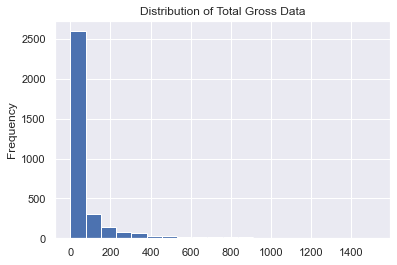

In [45]:
# Lets visualize the distribution of total gross data 
fig, axs = plt.subplots()
movie_gross_df['total_gross'].plot.hist(bins=20, ax=axs)
axs.set_title('Distribution of Total Gross Data');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


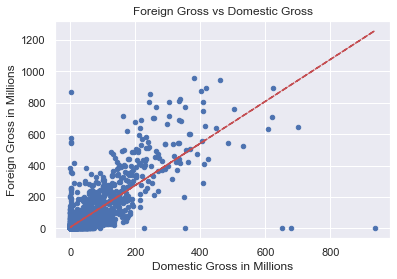

In [46]:
# Lets visually see the correlation between domestic and foreign gross
fig, axs = plt.subplots()
movie_gross_df.plot.scatter('domestic_gross', 'foreign_gross', ax=axs)
yhat = np.poly1d(np.polyfit(movie_gross_df['domestic_gross'], movie_gross_df['foreign_gross'],1))(movie_gross_df['domestic_gross'])
axs.plot(movie_gross_df['domestic_gross'], yhat, "r--")
axs.set_title('Foreign Gross vs Domestic Gross')
axs.set_xlabel('Domestic Gross in Millions')
axs.set_ylabel('Foreign Gross in Millions');

### The Numbers Analysis

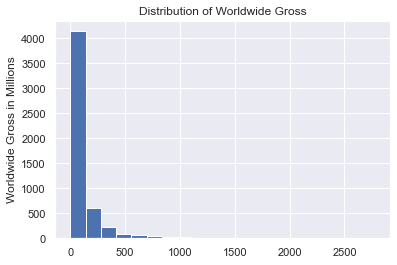

In [47]:
# Let's look at the distribution of worldwide gross to see how it is shaped 
fig, axs = plt.subplots()
budget_df['worldwide_gross'].plot.hist(bins=20, ax=axs)
axs.set_title('Distribution of Worldwide Gross')
axs.set_ylabel('Worldwide Gross in Millions');

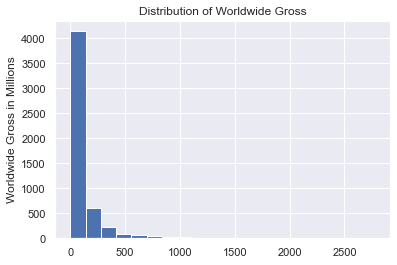

In [48]:
# Let's look at the distribution of worldwide gross to see how it is shaped 
fig, axs = plt.subplots()
budget_df['worldwide_gross'].plot.hist(bins=20, ax=axs)
axs.set_title('Distribution of Worldwide Gross')
axs.set_ylabel('Worldwide Gross in Millions');

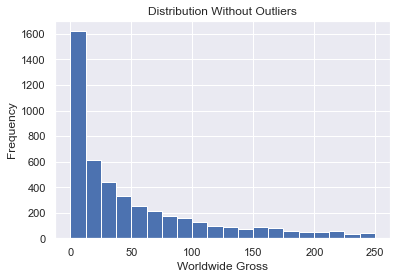

In [49]:
# Excludes all of the outliers to get a better visualization 
fig, axs = plt.subplots()
budget_df[budget_df['worldwide_gross'] <= 250]['worldwide_gross'].plot.hist(bins=20, ax=axs)
axs.set_title('Distribution Without Outliers')
axs.set_xlabel('Worldwide Gross');

### IMDB Analysis 

In [50]:
# removing rows with any null values
ratings_df.dropna(how='any', axis=0, inplace=True)

In [51]:
# creating a function to format genres
def clean_genres(genres):
    '''
    Takes a list of genres and builds a string from the list
    for easier aggregation and comparison. 
    -
    Input:
    genres : list of genres to be converted
    -
    Output:
    lowercase, comma-separated string built from list 
    '''
    genres = str(genres)
    genres_list = sorted(genres.lower().split(','))
    return ','.join(list(map(str, genres_list)))

In [52]:
# apply clean_genres function to ratings dataset
ratings_df['genres'] = ratings_df['genres'].apply(clean_genres)
ratings_df.head()

,averagerating,numvotes,primary_title,genres
0,7.0,77,sunghursh,"action,crime,drama"
2,6.9,4517,theothersideofthewind,drama
4,6.5,119,thewanderingsoapopera,"comedy,drama,fantasy"
6,8.1,263,joefindsgrace,"adventure,animation,comedy"
7,6.8,451,páladrienn,drama


### Highest-Rated Genres
To determine which genres had the highest average ratings, we first joined the __movie_basics__ and __movie_ratings__ tables to relate each movie's ID to its primary title.

We then grouped movies by genre and took the average rating of each genre. Through this, we found that the highest-rated genres were __documentary__ and __animation__.

In [53]:
# grouping ratings dataset by genre
ratings_df['genres'].value_counts()
sorted_by_avg = ratings_df.groupby('genres').mean().sort_values(by='averagerating', ascending=False)

In [54]:
# filter out movie genres with less than 62 total votes
sorted_avg_higher_votes = sorted_by_avg[sorted_by_avg['numvotes'] >= 62].head(15)
sorted_avg_higher_votes.reset_index(inplace=True)

We decided to filter out genres with less than 62 total votes based on the box-and-whisker plot below. The 25th percentile of votes per genre was 62.

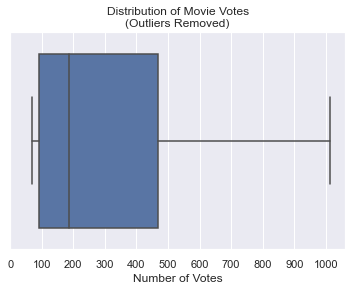

In [55]:
# outliers removed to improve quartile readability 
fig, ax = plt.subplots()
sns.boxplot(x = sorted_avg_higher_votes['numvotes'], showfliers=False, color='b');
ax.set_title('Distribution of Movie Votes\n(Outliers Removed)')
ax.set_xlabel('Number of Votes')
ax.set_xticks(range(0, 1051, 100));

In [56]:
# 15 highest-rated movie genres with more than 62 total votes
highest_rated_genres = sorted_avg_higher_votes[['genres', 'averagerating']]
highest_rated_genres['averagerating'] = highest_rated_genres['averagerating'].round(2)
highest_rated_genres

,genres,averagerating
0,"adventure,documentary,western",9.2
1,"adventure,sport",9.2
2,"documentary,drama,thriller",8.4
3,"mystery,news,thriller",8.4
4,"comedy,history,musical",8.3
5,"documentary,music,war",8.2
6,"documentary,fantasy,horror",8.2
7,"romance,thriller,war",8.2
8,"animation,documentary,mystery",8.2
9,"animation,crime,mystery",8.2


In [57]:
# make count of each of these individual genres in dictionary
top_genres = {}
for genre in sorted_avg_higher_votes['genres'].value_counts().index:
    genre_list = genre.split(',')
    for item in genre_list:
        if item not in top_genres:
            top_genres[item] = 1
        elif item in top_genres:
            top_genres[item] += 1
top_genres = dict(sorted(top_genres.items(), key = lambda x: x[1], reverse=True))

The chart below shows that the top two highest rated genres are __documentary__ and __animation__.

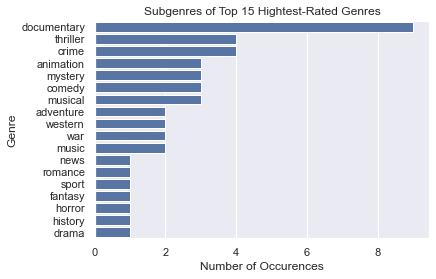

In [58]:
# bar chart showing most-used subgenres within top 15 highest-rated 
# movie genres
fig, ax = plt.subplots()
sns.barplot(x = list(top_genres.values()), y = list(top_genres.keys()), color = 'b');
ax.set_title('Subgenres of Top 15 Hightest-Rated Genres')
ax.set_xlabel('Number of Occurences')
ax.set_ylabel('Genre');

#### The Highest Performning Studio

In [59]:
# Lets inspect all of the studios to see if there is any duplicates w/misspellings
movie_gross_df['studio'].value_counts().sort_values(ascending=False)

IFC             166
Uni.            147
WB              140
Magn.           136
Fox             136
               ... 
AM                1
NAV               1
Darin Southa      1
DLA               1
AZ                1
Name: studio, Length: 256, dtype: int64

In [60]:
# Let's only look at studios that have more than 50 movies 
studio_50 = movie_gross_df.groupby("studio").filter(lambda x: len(x) > 50)

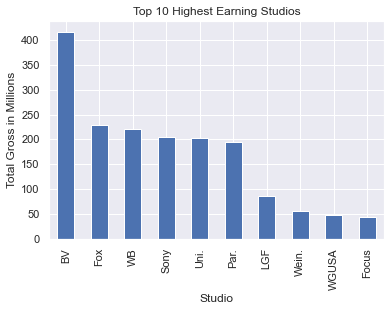

In [61]:
# Let's use the top 10 highest earners
fig, axs = plt.subplots()
studio_50.groupby('studio').mean()['total_gross'].sort_values(ascending=False)[:10].plot.bar(ax = axs)
axs.set_title('Top 10 Highest Earning Studios')
axs.set_ylabel('Total Gross in Millions')
axs.set_xlabel('Studio');

In [62]:
# Lets look at the movies that studio BV has done
movie_gross_df[movie_gross_df['studio'] == 'BV']

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,toystory3,BV,415.0,652.0,2010,1067.0
1,aliceinwonderland(2010),BV,334.2,691.3,2010,1025.5
7,tangled,BV,200.8,391.0,2010,591.8
13,tronlegacy,BV,172.1,228.0,2010,400.1
15,princeofpersia:thesandsoftime,BV,90.8,245.6,2010,336.4
...,...,...,...,...,...,...
3101,solo:astarwarsstory,BV,213.8,179.2,2018,393.0
3107,marypoppinsreturns,BV,172.0,177.6,2018,349.6
3120,disney'schristopherrobin,BV,99.2,98.5,2018,197.7
3122,thenutcrackerandthefourrealms,BV,54.9,119.1,2018,174.0


We wanted to compare the top-rated genres the genres of movies produced by the top-grossing movie production studio, which was Disney-Pixar (represented as BV studios in this dataset).

In [63]:
# dataframe with movie titles and studio
movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_gross_df['title'] = movie_gross_df['title'].str.lower()

In [64]:
# dataframe from database with movie titles and genres
movie_basics_df = pd.read_sql("""SELECT *
                                 FROM movie_basics
                                 WHERE start_year >= 2010""", conn)
movie_basics_df['primary_title'] = movie_basics_df['primary_title'].str.lower()

In [65]:
# inner join dataframes on title (movie_gross_df), primary_title (movie_basics_df)
movie_genre_studio_df = pd.merge(movie_gross_df, movie_basics_df, 
                                 left_on='title', right_on='primary_title',
                                 how='inner')
# drop movies with no genres
movie_genre_studio_df.dropna(subset=['genres'], inplace=True)
# clean genre string for each row
movie_genre_studio_df['genres'] = movie_genre_studio_df['genres'].apply(clean_genres)

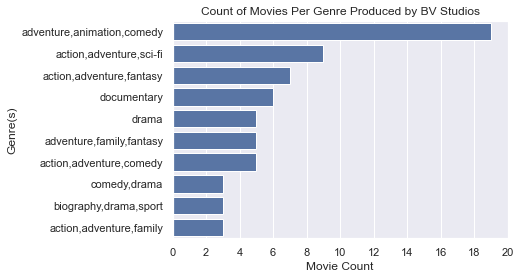

In [66]:
# put movies from highest-performing studio into a dataframe
bv_studio_movies = movie_genre_studio_df[movie_genre_studio_df['studio'] == 'BV']

# bar chart showing number of movies per genre for BV studios
fig, ax = plt.subplots()
sns.countplot(data=bv_studio_movies, y='genres', 
              order=bv_studio_movies['genres'].value_counts().iloc[:10].index,
              color = 'b')
ax.set_xticks(range(0,21,2))
ax.set_title('Count of Movies Per Genre Produced by BV Studios')
ax.set_xlabel('Movie Count')
ax.set_ylabel('Genre(s)');

### Recommendation 1
Because animation was present in both the top-rated genres and the list of genres from movies made by the highest-grossing production studio, __we recommend that Computer Vision produce a movie in the animation category.__

### Budget-to-Box Office Ratio

In [67]:
# Remove the years before 2010 where we saw a jump in worldwide gross
budget_df = budget_df[budget_df['release_date'] >= 2010]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


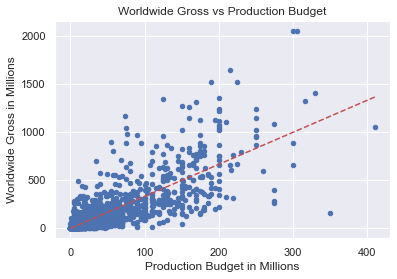

In [68]:
# Let's start off by checking the scatter plot of budget and worldwide gross to gain intuition
fig, axs = plt.subplots()
budget_df.plot.scatter('production_budget', 'worldwide_gross', ax = axs)
yhat = np.poly1d(np.polyfit(budget_df['production_budget'], budget_df['worldwide_gross'],1))(budget_df['production_budget'])
axs.plot(budget_df['production_budget'], yhat, "r--")
axs.set_title('Worldwide Gross vs Production Budget')
axs.set_xlabel('Production Budget in Millions')
axs.set_ylabel('Worldwide Gross in Millions');

In [69]:
# To be more concrete, lets also print out the correlation coefficient 
corr = np.corrcoef(budget_df['production_budget'], budget_df['worldwide_gross'])[0][1]
print(f'The correlation between production budget and worldwide gross is {corr}')

The correlation between production budget and worldwide gross is 0.7872721892906527


In [70]:
# Lets define a feature called budget to gross ratio 
budget_df['bg_ratio'] = budget_df['worldwide_gross']/budget_df['production_budget']
budget_df.bg_ratio.head()

1    2.546673
2    0.427892
3    4.243841
4    4.153696
5    6.710167
Name: bg_ratio, dtype: float64

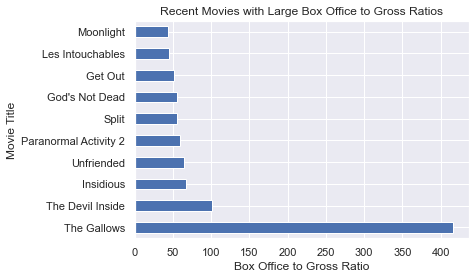

In [71]:
# Lets see the top 10 best films in terms of bg_ratio
fig, axs = plt.subplots()
budget_df['movie'] = budget_df['movie'].map(lambda x: x.replace('Godâs', "God's"))
budget_df.sort_values(by='bg_ratio', ascending=False)[:10].plot.barh('movie', 'bg_ratio', ax = axs, legend='Box Office to Gross Ratio')
axs.set_title('Recent Movies with Large Box Office to Gross Ratios')
axs.get_legend().remove()
axs.set_xlabel('Box Office to Gross Ratio')
axs.set_ylabel('Movie Title');

In [72]:
# Let's give some ordinality to our budgets to define low budget and high budget movies
avg_budget = budget_df['production_budget'].mean()
avg_budget

42.87490355344152

In [73]:
# Create a column that represents high budget and low budget movies
budget_df['high_budget'] = (budget_df['production_budget'] > avg_budget).astype(int)

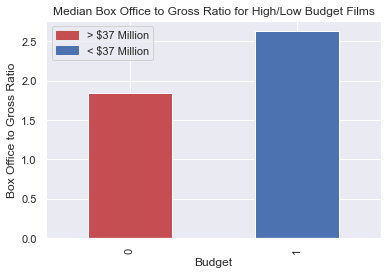

In [74]:
# Lets see the average and median bg_ratio for high budget and low budget films
fig, axs = plt.subplots()
colors = ['r', 'b']
budget_df.groupby('high_budget').median()['bg_ratio'].plot.bar(ax=axs, color = colors)
labels = ['> $37 Million', '< $37 Million']
handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors]
plt.legend(handles, labels)
axs.set_title('Median Box Office to Gross Ratio for High/Low Budget Films')
axs.set_xlabel('Budget')
axs.set_ylabel('Box Office to Gross Ratio');

In [75]:
# Lets take a look at the variances
budget_df.groupby('high_budget').std()

,id,release_date,production_budget,domestic_gross,worldwide_gross,bg_ratio
high_budget,,,,,,
0,28.111439,2.613051,12.233320,33.501665,68.331144,13.629455
1,29.039698,2.690428,59.838864,120.784789,324.756359,2.287961


As represented in the table above, high budget movies have a very low bg_ratio standard deviation, meaning that they are more consistent. This means it might be more profitable for Computer Vision to put forth a higher budget for their movie production. 

In [76]:
# To be concrete in giving a number, lets look at the top 300 best bg_ratio films and see what their average budget is 
prod_bud_bg = budget_df.sort_values(by='bg_ratio', ascending=False)['production_budget'][:300].mean()

In [77]:
# Next lets look at the top 300 best worldwide grossing films and see what that average is 
prod_bud_ww = budget_df.sort_values(by='worldwide_gross', ascending=False)['production_budget'][:300].mean()

In [78]:
# To give a concrete number on how much to spend, lets average these two together
print(f'The studio should spend {(prod_bud_bg + prod_bud_ww)/2} on the film')

The studio should spend 80.29773941666667 on the film


### Recommendation 2
Based on the budget-to-box office gross ratio and the high positive correlation between production budget and worldwide gross, __we recommend that Computer Vision spend approximately $80 million on producing their first movie.__

## Statistical Communication

After identifying __animation__ as the genre Computer Vision should pursue, we wanted to explore the difference between the genre's foreign and domestic gross. 

We hypothesized that:
- A movie in the animation category will gross higher internationally than domestically. 

Based on the results of our t-test, we can determine where to allocate more marketing efforts to maximize profitability.

### T-test
We want to know if __animation__ movies gross more internationally or domestically. 
- We chose the __animation__ genre because it is one of the genres with the highest average ratings, and appears as a genre in highly-grossing films from the highest-grossing studio (BV Studios, which turns out to be Disney/Pixar).

Our __null hypothesis__ is that the animation genre grosses the same internationally and domestically.

Our __alternative__ hypothesis is that animation movies gross more internationally than domestically. 

In [79]:
# Lets join the movie_gross_df and ratings_df together 
combined = pd.merge(movie_gross_df, ratings_df, left_on='title', 
                    right_on="primary_title")
combined.head()

,title,studio,domestic_gross,foreign_gross,year,averagerating,numvotes,primary_title,genres
0,inception,WB,292600000.0,535700000,2010,8.8,1841066,inception,"action,adventure,sci-fi"
1,tangled,BV,200800000.0,391000000,2010,7.8,366366,tangled,"adventure,animation,comedy"
2,megamind,P/DW,148400000.0,173500000,2010,7.3,207488,megamind,"action,animation,comedy"
3,salt,Sony,118300000.0,175200000,2010,6.4,277204,salt,"action,mystery,thriller"
4,red,Sum.,90400000.0,108600000,2010,7.1,271570,red,"action,comedy,crime"


In [80]:
# First, lets get the dataframe of only animation movies 
genre_to_grab = "animation"

ttest_df = combined[combined['genres'].str.contains(genre_to_grab)][['domestic_gross', 'foreign_gross']]


In [81]:
# Lets check to see if we have enough samples
len(ttest_df)

27

In [82]:
# Lets look at the statistics to give us a basis for our intuition
ttest_df.describe()

,domestic_gross
count,2.700000e+01
mean,1.356752e+08
std,1.114261e+08
min,1.000000e+03
25%,6.435000e+07
50%,1.075000e+08
75%,2.052500e+08
max,4.007000e+08


In [83]:
# Lets sample from our data
domestic_sample = ttest_df['domestic_gross'].sample(100)
foreign_sample = ttest_df['foreign_gross'].sample(100)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
# Lets perform a one tailed two sample t test
import scipy.stats as stats
alpha = .05
tstat, pvalue = stats.ttest_ind(domestic_sample, foreign_sample, equal_var=False)

answer = 'Reject null hypothesis' if pvalue < alpha else 'Fail to reject null hypothesis'
print(answer)

In [ ]:
# Plot the t statistic on a t distribution
tval_alpha = stats.t.ppf(.05, 99)
x = np.linspace(-5,5,1000)
y = stats.t.pdf(x, 99)
fig, axs = plt.subplots()
axs.plot(x,y)
axs.axvline(tstat)
axs.axvline(tval_alpha)
axs.axvspan(-5, tval_alpha, alpha=0.5, color='red')
plt.text(tval_alpha + .1 ,.3,'reject region',rotation=90)
plt.text(tstat + .1 ,.3,'t statistic',rotation=90)
axs.set_title('T-Distribution w/D.F = 99');

The results of our statistical test show that with 95% confidence we can conclude foreign gross is significantly greater than domestic gross regarding movies with the __animation__ genre. 
- This indicates that more money should be spent marketing to foreign markets as opposed to domestic.

### Recommendation 3
Based on the above analysis, __we recommend that Computer Vision focus marketing efforts towards international audiences over domestic audiences.__

## Conclusion
Computer Vision tasked us with providing insight regarding what types of movies to make, as they would like to establish a movie production studio. 

We have recommended three courses of action based on thorough data exploration and analysis, and the three high-priority metrics mentioned previously. 

### Summary of Recommendations
- __Computer Vision should produce a movie in the animation genre.__
- __Computer vision should spend approximately $80 million towards the production of their first movie.__
- __Computer vision should allocate more marketing efforts and funds towards the international market versus the domestic market.__

### Next Steps
- We would like to continue to test our hypothesis and compare our recommendations to those that would be produced from unused datasets. 
- We would like to collect more recent movie rating and box office data for analysis .
- We would like to conduct more thorough analysis regarding how much money should be allocated towards international versus domestic marketing efforts. 